In [1]:

import tensorflow as tf

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [2]:
data = pd.read_csv('./train_x.csv').as_matrix()
labels = pd.read_csv('./train_y.csv').as_matrix()


In [3]:
data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:

print(data.shape)

(193890, 784)


In [5]:
image_width = image_height = np.ceil(np.sqrt(784)).astype(np.uint8)
print(image_width)

28


[0 0 1 0 0 0 0 0 0 0]


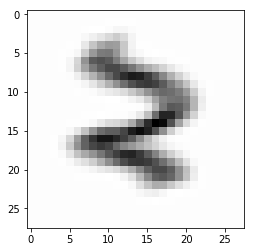

In [39]:
image = data[3].reshape(image_width,image_height)
plt.imshow(image.T,cmap=cm.binary)
print(labels[3])

In [7]:
VALIDATION_SIZE=10000
validation_images = data[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = data[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]

In [8]:
def weight_variable(shape):
    init = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init)

def bias_variable(shape):
    init = tf.constant(0.1, shape=shape)
    return tf.Variable(init)

In [9]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [10]:
con1_w=weight_variable([5,5,1,32])
con1_b=bias_variable([32])

In [11]:
image_size=784
labels_count=10

In [12]:
x = tf.placeholder('float', shape=[None, image_size])
y_ = tf.placeholder('float', shape=[None, labels_count])

In [13]:
image = tf.reshape(x, [-1,28,28,1])

In [14]:
image.get_shape()

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)])

In [15]:
con1=tf.nn.relu(conv2d(image,con1_w)+con1_b)
con1_pool=max_pool_2x2(con1)

# display 32 fetures in 4 by 8 grid
layer1 = tf.reshape(con1, (-1, image_height, image_width, 4 ,8))  
# reorder so the channels are in the first dimension, x and y follow.
layer1 = tf.transpose(layer1, (0, 3, 1, 4,2))
layer1 = tf.reshape(layer1, (-1, image_height*4, image_width*8)) 

In [16]:
con1_pool.get_shape()

TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(32)])

In [17]:
con2_w=weight_variable([5,5,32,64])
con2_b=bias_variable([64])

In [18]:
con2=tf.nn.relu(conv2d(con1_pool,con2_w)+con2_b)
con2_pool=max_pool_2x2(con2)

layer2 = tf.reshape(con2, (-1, 14, 14, 4 ,16))  
layer2 = tf.transpose(layer2, (0, 3, 1, 4,2))
layer2 = tf.reshape(layer2, (-1, 14*4, 14*16)) 

In [19]:
con2_pool.get_shape()

TensorShape([Dimension(None), Dimension(7), Dimension(7), Dimension(64)])

In [20]:
dens_w = weight_variable([7 * 7 * 64, 1024])
dens_b= bias_variable([1024])

In [21]:
con2_flat= tf.reshape(con2_pool, [-1, 7*7*64])

dens = tf.nn.relu(tf.matmul(con2_flat,dens_w) + dens_b)

In [22]:
con2_flat.get_shape()

TensorShape([Dimension(None), Dimension(3136)])

In [23]:
keep_prob=tf.placeholder('float')
drop_out=tf.nn.dropout(dens,keep_prob)

In [24]:
drop_out.get_shape()

TensorShape([Dimension(None), Dimension(1024)])

In [25]:
softmax_w=weight_variable([1024,labels_count])
softmax_b=bias_variable([labels_count])

In [26]:
y=tf.nn.softmax(tf.matmul(drop_out,softmax_w)+softmax_b)

In [27]:
LEARNING_RATE=1e-4
# cost function
cross_entropy = -tf.reduce_sum(y_*tf.log(y))
# optimisation function
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)
# evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
predict = tf.argmax(y,1)

In [29]:
idx = 0
num_examples = train_images.shape[0]

def next_batch(batch_size):
    
    global train_images
    global train_labels
    global idx

    start=idx
    idx+= batch_size  
    
    if idx>num_examples:

        new_idx=np.arange(num_examples)
        np.random.shuffle(new_idx)
        train_images =  train_images[new_idx]
        train_labels =  train_labels[new_idx]

        start = 0
        idx= batch_size
        #assert batch_size <= num_examples
    end=idx
    return train_images[start:end], train_labels[start:end]

In [30]:
train_images.shape[0]

183890

In [44]:
init= tf.global_variables_initializer()
sess=tf.InteractiveSession()
sess.run(init)

In [45]:
train_accuracies = []
validation_accuracies = []

TRAINING_ITERATIONS=1901
BATCH_SIZE = 150

for i in range(TRAINING_ITERATIONS):
    batch_xs, batch_ys = next_batch(BATCH_SIZE)        
    if not(i%100):
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs,  y_: batch_ys,keep_prob: 1.0})
        _idx=np.arange(VALIDATION_SIZE)
        np.random.shuffle(_idx)
        validation_images =  validation_images[_idx]
        validation_labels =  validation_labels[_idx]

        validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:BATCH_SIZE], 
                                                        y_: validation_labels[0:BATCH_SIZE], 
                                                        keep_prob: 1.0})   
        
        print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
        
        validation_accuracies.append(validation_accuracy)
        train_accuracies.append(train_accuracy)

            
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: .5})

training_accuracy / validation_accuracy => 0.10 / 0.09 for step 0
training_accuracy / validation_accuracy => 0.83 / 0.79 for step 100
training_accuracy / validation_accuracy => 0.85 / 0.83 for step 200
training_accuracy / validation_accuracy => 0.91 / 0.81 for step 300
training_accuracy / validation_accuracy => 0.89 / 0.87 for step 400
training_accuracy / validation_accuracy => 0.89 / 0.94 for step 500
training_accuracy / validation_accuracy => 0.91 / 0.87 for step 600
training_accuracy / validation_accuracy => 0.91 / 0.90 for step 700
training_accuracy / validation_accuracy => 0.95 / 0.92 for step 800
training_accuracy / validation_accuracy => 0.95 / 0.97 for step 900
training_accuracy / validation_accuracy => 0.95 / 0.97 for step 1000
training_accuracy / validation_accuracy => 0.96 / 0.95 for step 1100
training_accuracy / validation_accuracy => 0.95 / 0.93 for step 1200
training_accuracy / validation_accuracy => 0.95 / 0.95 for step 1300
training_accuracy / validation_accuracy => 0.9

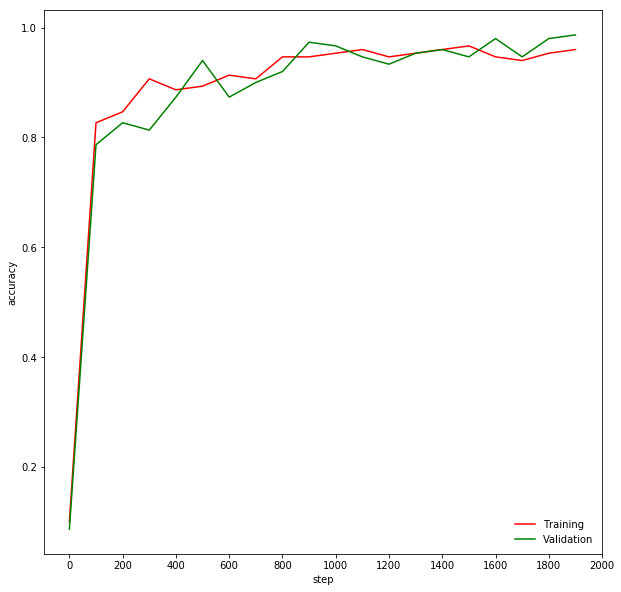

In [77]:
tmp=np.arange(0,1901,100)
plt.figure(figsize=(10, 10))
plt.plot(tmp, train_accuracies,'-r', label='Training')
plt.plot(tmp, validation_accuracies,'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.xticks(np.arange(0,2100,200))
plt.ylabel('accuracy')
plt.xlabel('step')
plt.show()

In [48]:
test_images = pd.read_csv('./test_x.csv').as_matrix()
test_label = pd.read_csv('./test_y.csv').as_matrix()

In [49]:

# using batches is for more resource efficient
predicted_lables = np.zeros(test_images.shape[0])

tmp = test_images.shape[0]//BATCH_SIZE
test_accuracies=[]
for i in range(0,tmp):
    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE], keep_prob: 1.0})
    
    test_accuracy=accuracy.eval(feed_dict={ x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE], 
                                                        y_: test_label[i*BATCH_SIZE : (i+1)*BATCH_SIZE], 
                                                        keep_prob: 1.0})
    print('Test Accuricy => %.2f for step %d'%(test_accuracy,i))
    test_accuracies.append(test_accuracy)                                                                          


Test Accuricy => 0.98 for step 0
Test Accuricy => 0.99 for step 1
Test Accuricy => 0.86 for step 2
Test Accuricy => 0.69 for step 3
Test Accuricy => 0.68 for step 4
Test Accuricy => 0.89 for step 5
Test Accuricy => 0.99 for step 6
Test Accuricy => 0.99 for step 7
Test Accuricy => 0.99 for step 8
Test Accuricy => 0.95 for step 9
Test Accuricy => 0.95 for step 10
Test Accuricy => 0.95 for step 11
Test Accuricy => 0.99 for step 12
Test Accuricy => 0.92 for step 13
Test Accuricy => 0.91 for step 14
Test Accuricy => 0.83 for step 15
Test Accuricy => 0.98 for step 16
Test Accuricy => 0.98 for step 17
Test Accuricy => 0.97 for step 18
Test Accuricy => 1.00 for step 19
Test Accuricy => 0.97 for step 20
Test Accuricy => 0.97 for step 21
Test Accuricy => 0.98 for step 22
Test Accuricy => 0.97 for step 23
Test Accuricy => 0.87 for step 24
Test Accuricy => 0.90 for step 25


In [50]:
print('Accuricy => %2.2f%%'%(sum(test_accuracies)/len(test_accuracies)*100))

Accuricy => 92.97%


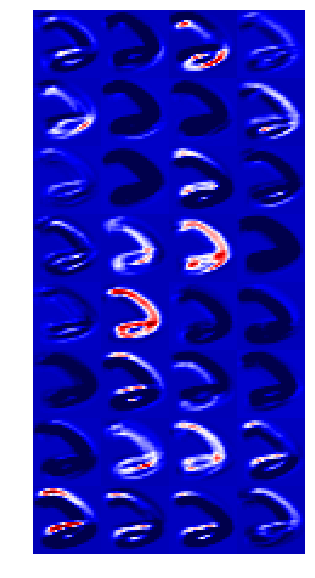

In [76]:
layer1_grid = layer1.eval(feed_dict={x: test_images[600:650], keep_prob: 1.0})
plt.figure(figsize=(8,10))
plt.axis('off')
plt.imshow(layer1_grid[0].T, cmap=cm.seismic )

8.0
3.0
3.0
7.0
7.0
9.0
6.0
8.0
4.0
6.0


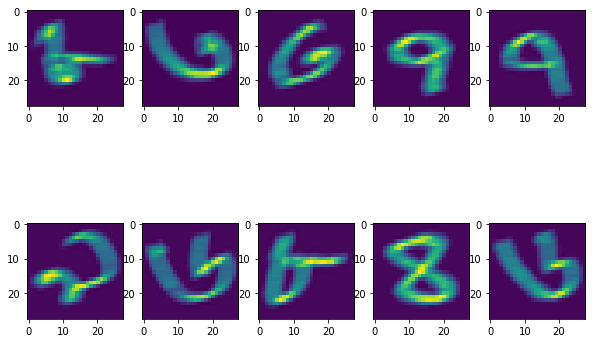

In [75]:
fig=plt.figure(figsize=(10, 15))
for i in range(1,11):
    a=np.random.randint(0,3999)
    print(predicted_lables[a])
    fig.add_subplot(4,5, i)
    plt.imshow((test_images[a].reshape(28,28)).T)

In [78]:
sess.close()